In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy import stats
import datetime as dt
from datetime import timedelta
from sklearn.tree import DecisionTreeRegressor
import sys
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.formula.api as smf
import scipy.stats as stats

In [5]:
SPP_path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)'

def add_info(df):
    intervals = df[df.columns[0]].values.tolist()
    dates = []
    times = []
    weekday = []
    months = []
    days = []
    hour = []
    minute_of_day = []
    for interval in intervals:
        date = interval.split(' ')[0]
        try:
            date = dt.datetime.strptime(date,'%Y-%m-%d').date()
        except:
            date = dt.datetime.strptime(date,'%m/%d/%Y').date()            
        dates.append(date)
        months.append(date.month)
        days.append(date.day)
        if date.weekday() < 5:
            weekday.append(True)
        else:
            weekday.append(False)
        time = interval.split(' ')[1].split('.')[0]
        time = dt.datetime.strptime(time,'%H:%M:%S').time()
        times.append(time)
        hour.append(dt.time(time.hour))
        minute_of_day.append(60*time.hour+time.minute)
    df['Local Date'] = np.array(dates)
    df['Local Time'] = np.array(times)
    df['Hour'] = np.array(hour)
    df['Weekday'] = np.array(weekday)
    df['Month'] = np.array(months)
    df['Day'] = np.array(days)
    df['Minute of Day'] = np.array(minute_of_day)
    return df

def GMT2CT(s):
    date = s.split('T')[0]
    date = dt.datetime.strptime(date,'%Y-%m-%d').date()
    time = s.split('T')[1][:-1]
    hour = int(time.split(':')[0])
    if hour >= 6:
        hour = hour - 6
    else:
        hour = 24 + (hour - 6)
        date = date - timedelta(1)
    time = str(hour) + ':' + time.split(':')[1] + ':' + time.split(':')[2]
    time = dt.datetime.strptime(time,'%H:%M:%S').time()
    return [date, time]

In [6]:
gen_mix_2018 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2018.csv')
list_intervals = gen_mix_2018[gen_mix_2018.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2018['Local Date'] = np.array(local_date)
gen_mix_2018['Local Time'] = np.array(local_time)

In [7]:
days_31 = []
for n in range(1,10):
    days_31.append('0'+str(n))
for n in range(10,32):
    days_31.append(str(n))
cal_dict = {'01':days_31,
            '02':days_31[0:28],
            '03':days_31,
           '04':days_31[0:-1],
            '05':days_31,
            '06':days_31[0:-1],
           '07':days_31,
            '08':days_31,
            '09':days_31[0:-1],
           '10':days_31,
           '11':days_31[0:-1],
           '12':days_31}

In [9]:
# Opening and concatenating RT datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\RT\2018'
RT_path = 'RTBM-LMP-DAILY-SL-2018'
end = '.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+RT_path+key+value+end))
RT = pd.concat(dfs)

In [10]:
# Aggregating settlement location for system-wide data
RT2018_aggloc = RT.groupby('Interval')[['Interval',' LMP']].agg({'Interval':'first',
                                                                    ' LMP':'mean'})
RT2018 = add_info(RT2018_aggloc)
RT2018 = RT2018.rename(columns={' LMP':'LMP'})
RT2018.head()

,Interval,LMP,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
Interval,,,,,,,,,
01/01/2018 00:05:00,01/01/2018 00:05:00,246.567610,2018-01-01,00:05:00,00:00:00,True,1,1,5
01/01/2018 00:10:00,01/01/2018 00:10:00,64.864068,2018-01-01,00:10:00,00:00:00,True,1,1,10
01/01/2018 00:15:00,01/01/2018 00:15:00,164.686048,2018-01-01,00:15:00,00:00:00,True,1,1,15
01/01/2018 00:20:00,01/01/2018 00:20:00,173.867912,2018-01-01,00:20:00,00:00:00,True,1,1,20
01/01/2018 00:25:00,01/01/2018 00:25:00,163.353003,2018-01-01,00:25:00,00:00:00,True,1,1,25


In [11]:
# Opening and concatenating DA datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA\2018'
DA_path = 'DA-LMP-SL-2018'
end = '0100.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+DA_path+key+value+end))
DA2018 = pd.concat(dfs)

In [12]:
# Aggregating settlement location for system-wide data
DA2018_aggloc = DA2018.groupby('Interval')[['Interval','LMP']].agg({'Interval':'first',
                                                                    'LMP':'mean'})
DA2018_aggloc = add_info(DA2018_aggloc)
DA2018_aggloc.head()

,Interval,LMP,Local Date,Local Time,Hour,Weekday,Month,Day,Minute of Day
Interval,,,,,,,,,
01/01/2018 01:00:00,01/01/2018 01:00:00,37.390157,2018-01-01,01:00:00,01:00:00,True,1,1,60
01/01/2018 02:00:00,01/01/2018 02:00:00,37.249877,2018-01-01,02:00:00,02:00:00,True,1,1,120
01/01/2018 03:00:00,01/01/2018 03:00:00,37.998882,2018-01-01,03:00:00,03:00:00,True,1,1,180
01/01/2018 04:00:00,01/01/2018 04:00:00,40.778408,2018-01-01,04:00:00,04:00:00,True,1,1,240
01/01/2018 05:00:00,01/01/2018 05:00:00,42.051515,2018-01-01,05:00:00,05:00:00,True,1,1,300


In [13]:
def ssr(prediction, test):
    return ((prediction - test)**2).sum()
def pe(prediction, test):
    return (abs((prediction - test)/test))*100
def filler(df, DA):
    price_list = df[DA].values.tolist()
    value = 0.0
    new_list = []
    for price in price_list:
        if math.isnan(price)==True:
            new_list.append(value)
        else:
            value = price
            new_list.append(price)
    df[DA] = np.array(new_list)
    return df
def means_dict(d):
    means_d = {}
    for key in d.keys():
        means_d[key] = np.nanmean(np.array(d[key]))
    return means_d

In [14]:
# Merging RT, DA and Load data
comparison = DA2018_aggloc.iloc[:,0:2].join(RT2018,how='right',lsuffix='_DA',rsuffix='_RT')
DART2018_5min = filler(comparison, 'LMP_DA')
gen_2018 = gen_mix_2018
new_index = []
for i in range(gen_2018.shape[0]):
    new_index.append(gen_2018['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + gen_2018['Local Time'].iloc[i].strftime("%H:%M:%S"))
gen_2018.index = np.array(new_index)
DART_gen_2018 = gen_2018.join(DART2018_5min,how='right',lsuffix='_gen',rsuffix='_price')
DART_gen_2018 = DART_gen_2018.rename(columns={' Average Actual Load':'Load',
                                             ' Wind Self':'Wind',
                                             ' Coal Market':'Coal_Mkt',
                                             ' Coal Self':'Coal_Self',
                                             'Local Time_price':'Local Time'})

In [15]:
def sklearn_clusters_2(train_df, depth, plot):
    # converting datetime to int
    minutes = []
    for time in train_df.index:
        minutes.append(time.hour * 60 + time.minute)
    train_df['minutes'] = np.array(minutes)
    X = train_df['minutes'].values.reshape(-1,1)
    y = train_df['LMP_RT']
    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=depth)
    regr_1.fit(X, y)
    # Predict
    X_test = train_df['minutes'].values.reshape(-1,1)
    y_1 = regr_1.predict(X_test)
    train_df['sklearn cluster'] = y_1
    price_leaves = []
    for price in y_1:
        if price not in price_leaves:
            price_leaves.append(price)
    branch_dfs = []
    for price in price_leaves:
        branch_dfs.append(train_df[train_df['sklearn cluster']==price])
    if plot == True:
        plt.plot(X_test, y_1, color="cornflowerblue",label="max_depth="+str(depth), linewidth=2)
        plt.legend()
    return branch_dfs

In [16]:
# Opening and concatenating DA Load datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA Load\2018'
DA_path = 'DA-MC-2018'
end = '0100.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\'+DA_path+key+value+end))
DA_load_2018 = pd.concat(dfs)

In [17]:
# Merging Forecast Load to dataset
DA_load_2018.index = DA_load_2018['Interval']
comparison = DA_load_2018.iloc[:,8:9].join(DART_gen_2018,how='right')
DART2018 = filler(comparison, ' Total Demand')
DART2018 = DART2018.iloc[11:,:]
DART2018 = DART2018.rename(columns={' Total Demand':'DA Load'})
DART2018['Load_Diff'] = DART2018['Load'] - DART2018['DA Load']

In [18]:
# Adding previous-interval and moving averages
DART2018_1 = DART2018.iloc[1:,:]
previous_load_diff = DART2018['Load_Diff'].iloc[0:-1].values
DART2018_1['Previous_Load_Diff'] = previous_load_diff
previous_RT = DART2018['LMP_RT'].iloc[0:-1].values
DART2018_1['Previous_RT'] = previous_RT

step = 3
previous_RT = DART2018_1['LMP_RT'].iloc[0:(DART2018_1.shape[0] - step)].values
previous_means_RT = np.empty(previous_RT.size)
previous_load = DART2018_1['Load_Diff'].iloc[0:(DART2018_1.shape[0] - step)].values
previous_means_load = np.empty(previous_load.size)
for i in range(DART2018_1.shape[0] - step):
    previous_means_RT[i] = previous_RT[i:i+step].mean()
    previous_means_load[i] = previous_load[i:i+step].mean()
DART2018_2 = DART2018_1.iloc[step:,:]
DART2018_2['Previous_RT_2'] = previous_means_RT
DART2018_2['Previous_Load_Diff_2'] = previous_means_load

DART2018_2.head()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,DA Load,GMT MKT Interval,Coal_Mkt,Coal_Self,Diesel Fuel Oil Market,Diesel Fuel Oil Self,Hydro Market,Hydro Self,Natural Gas Market,Gas Self,...,Hour,Weekday,Month,Day,Minute of Day,Load_Diff,Previous_Load_Diff,Previous_RT,Previous_RT_2,Previous_Load_Diff_2
Interval,,,,,,,,,,,,,,,,,,,,,
01/01/2018 01:20:00,36085.6,2018-01-01T07:20:00Z,2991.5,18157.5,0.0,0.0,43.7,486.7,6054.3,2961.2,...,01:00:00,True,1,1,80,-0.286,4.404,24.118414,27.302014,18.136000
01/01/2018 01:25:00,36085.6,2018-01-01T07:25:00Z,3000.8,18190.0,0.0,0.0,43.8,486.1,6031.1,2948.6,...,01:00:00,True,1,1,85,21.518,-0.286,24.729624,26.031712,8.197667
01/01/2018 01:30:00,36085.6,2018-01-01T07:30:00Z,3003.2,18246.4,0.0,0.0,43.5,486.4,6089.9,2958.0,...,01:00:00,True,1,1,90,-8.024,21.518,28.389152,25.745730,8.545333
01/01/2018 01:35:00,36085.6,2018-01-01T07:35:00Z,3004.7,18273.8,0.0,0.0,43.1,486.0,6142.3,2938.2,...,01:00:00,True,1,1,95,-36.888,-8.024,28.267911,27.128896,4.402667
01/01/2018 01:40:00,36085.6,2018-01-01T07:40:00Z,3008.3,18229.0,0.0,0.0,43.9,486.9,6171.6,2894.4,...,01:00:00,True,1,1,100,-102.888,-36.888,32.869229,29.842097,-7.798000


In [88]:
DART2018_2['Spread'] = DART2018_2['LMP_DA'] - DART2018_2['LMP_RT']

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [96]:
# comparing features

np.seterr(divide='print',invalid='print')

n = 10
PE_11_list = []
PE_10_list = []
errors = 0

for i in range(n):
    for j in range(1,13):
        by_month = DART2018_2[DART2018_2['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2', 'Spread']].mean()
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff', 
                                                'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2', 'Spread']].mean()
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (11)'] = np.zeros(test_data_copy.index.shape[0])
        test_data_copy['fitted RT (10)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        for cluster in branch_dfs:
            try:
                result11 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Spread + Load_Diff + 
                                    Previous_Load_Diff + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=cluster).fit()
                result10 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Load_Diff + 
                                    Previous_Load_Diff + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=cluster).fit()
                for hour in cluster.index:
                    test_data_copy['fitted RT (11)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result11.params[11] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result11.params[10] +  
                                                test_data_copy['Previous_Load_Diff_2'].loc[hour]*result11.params[9] + 
                                                test_data_copy['Previous_Load_Diff'].loc[hour]*result11.params[8] + 
                                                test_data_copy['Load_Diff'].loc[hour]*result11.params[7] + 
                                                test_data_copy['Spread'].loc[hour]*result11.params[6] + 
                                                test_data_copy['Wind'].loc[hour]*result11.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result11.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result11.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result11.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result11.params[1] + 
                                                result11.params[0])
                    test_data_copy['fitted RT (10)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result10.params[10] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result10.params[9] +
                                                test_data_copy['Previous_Load_Diff_2'].loc[hour]*result10.params[8] + 
                                                test_data_copy['Previous_Load_Diff'].loc[hour]*result10.params[7] + 
                                                test_data_copy['Load_Diff'].loc[hour]*result10.params[6] + 
                                                test_data_copy['Wind'].loc[hour]*result10.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result10.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result10.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result10.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result10.params[1] + 
                                                result10.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
        PE_11_list.append(pe(test_data_copy['fitted RT (11)'], test_data_copy['LMP_RT']).mean())
        PE_10_list.append(pe(test_data_copy['fitted RT (10)'], test_data_copy['LMP_RT']).mean())
        
    print(f'\r{10*i}%',end='')

PE_11_array = np.array(PE_11_list)
PE_10_array = np.array(PE_10_list)

print('\nMAPE \u00B1 std')
print('11 predictors: {} \u00B1 {}'.format(PE_11_array.mean(), PE_11_array.std()))
print('10 predictors: {} \u00B1 {}'.format(PE_10_array.mean(), PE_10_array.std()))
print('# of errors: {}'.format(errors))

90%
MAPE ± std
11 predictors: 0.13544780806061638 ± 0.41024435728440817
10 predictors: 10.341548691723187 ± 5.469693802452452
# of errors: 0


Of course, we can't add spread as a feature. But it was an interesing test to see how smf cleverly reads the data.

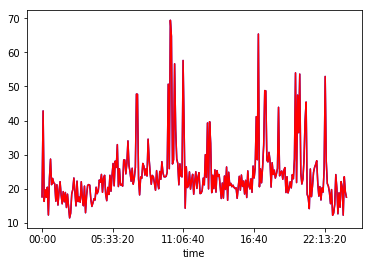

In [92]:
plt.plot(test_data_copy.index, test_data_copy['fitted RT (11)'], 'blue')
plt.plot(test_data_copy.index, test_data_copy['LMP_RT'], 'red')

Let's only train and test weekdays.

In [35]:
weekdays = DART2018_2[DART2018_2['Weekday']==True]

In [19]:

np.seterr(divide='print',invalid='print')

n = 10
PE_10_list = []
errors = 0

df = DART2018_2

for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]

        train, test = train_test_split(by_month, test_size=0.5)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff',
                                                  'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Load_Diff', 'Previous_Load_Diff', 
                                                'Previous_RT', 'Previous_Load_Diff_2', 'Previous_RT_2']].mean()
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (10)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        for cluster in branch_dfs:
            try:
                result10 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Load_Diff + Previous_Load_Diff
                                    + Previous_Load_Diff_2 + Previous_RT + Previous_RT_2""", data=cluster).fit()
                for hour in cluster.index:
                    test_data_copy['fitted RT (10)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result10.params[10] +  
                                                test_data_copy['Previous_RT'].loc[hour]*result10.params[9] +
                                                test_data_copy['Previous_Load_Diff_2'].loc[hour]*result10.params[8] + 
                                                test_data_copy['Previous_Load_Diff'].loc[hour]*result10.params[7] + 
                                                test_data_copy['Load_Diff'].loc[hour]*result10.params[6] + 
                                                test_data_copy['Wind'].loc[hour]*result10.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result10.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result10.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result10.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result10.params[1] + 
                                                result10.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
        PE_10_list.append(pe(test_data_copy['fitted RT (10)'], test_data_copy['LMP_RT']).mean())
        
    print(f'\r{100*(i+1)/n}%',end='')

PE_10_array = np.array(PE_10_list)

print('\nMAPE \u00B1 std')
print('10 predictors: {} \u00B1 {}'.format(PE_10_array.mean(), PE_10_array.std()))
print('# of errors: {}'.format(errors))

100.0%
MAPE ± std
10 predictors: 7.595307424981102 ± 2.1803716633885495
# of errors: 0


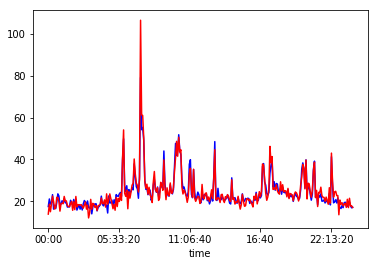

In [23]:
plt.plot(test_data_copy.index, test_data_copy['fitted RT (10)'], 'blue')
plt.plot(test_data_copy.index, test_data_copy['LMP_RT'], 'red')

In [26]:
train.shap

(4464, 41)

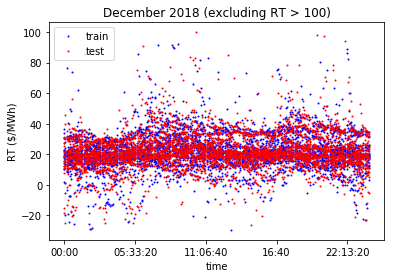

In [29]:
plt.plot(train[train['LMP_RT']<100]['Local Time'], train[train['LMP_RT']<100]['LMP_RT'], 'bo', ms=1, label='train')
plt.plot(test[test['LMP_RT']<100]['Local Time'], test[test['LMP_RT']<100]['LMP_RT'], 'ro', ms=1, label='test')
plt.title('December 2018 (excluding RT > 100)')
plt.ylabel('RT ($/MWh)')
plt.legend()

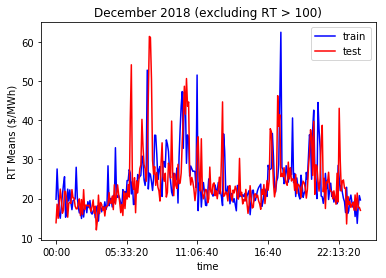

In [33]:
plt.plot(train_data[train_data['LMP_RT']<100].index, train_data[train_data['LMP_RT']<100]['LMP_RT'], 'blue', ms=1, label='train')
plt.plot(test_data[test_data['LMP_RT']<100].index, test_data[test_data['LMP_RT']<100]['LMP_RT'], 'red', ms=1, label='test')
plt.title('December 2018 (excluding RT > 100)')
plt.ylabel('RT Means ($/MWh)')
plt.legend()

All data
test size = 0.33 -> MAPE = 10.0
test size = 0.4 -> MAPE = 8.5
test size = 0.5 -> MAPE = 7.5
test size = 0.75 -> MAPE = 9.4

Weekdays
test size = 0.33 -> MAPE = 12.9
test size = 0.4 -> MAPE = 9.8
test size = 0.5 -> MAPE = 8.3
test size = 0.75 -> MAPE = 10.6

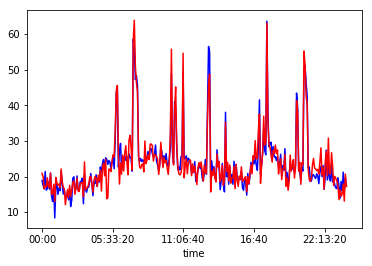

In [60]:
plt.plot(test_data_copy.index, test_data_copy['fitted RT (10)'], 'blue')
plt.plot(test_data_copy.index, test_data_copy['LMP_RT'], 'red')

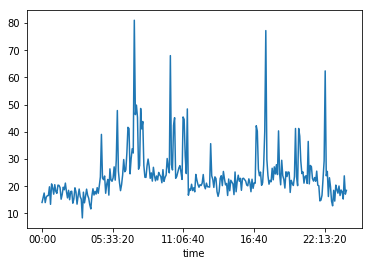

In [59]:
plt.plot(train_data[train_data['LMP_RT']<100].index,train_data[train_data['LMP_RT']<100]['LMP_RT'])